# EDA - Nivel 3

## Nivel 3: Datos Complejos, NLP y Estadística

En este nivel final, nos enfrentamos a la realidad de los datos "sucios" y complejos. Trabajaremos con fechas, texto libre y categorías con cientos de opciones.

Nos enfocaremos en:

- **Fechas:** Extraer inteligencia de columnas de tiempo.
- **Alta Cardinalidad:** ¿Qué hacer con categorías que tienen 100+ opciones?
- **NLP Básico:** Extraer información de texto (títulos de proyectos).
- **Transformaciones:** Logaritmos para datos sesgados y PCA para reducción de dimensiones.
- **Validación Estadística:** Ir más allá de los gráficos con tests de hipótesis.

Usaremos el dataset de **Kickstarter Projects**, analizando qué hace que un proyecto tenga éxito o fracase.

Fuente: [Kicksarter Projects](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

# 1. CARGA Y LIMPIEZA INICIAL
### Objetivo
Limpiar el ruido. Los datasets reales vienen con IDs internos, columnas duplicadas y formatos de fecha incorrectos.

In [32]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [33]:
# Importamos el dataset

base_dir = Path.cwd()
csv_file_path = base_dir.parent.parent.parent / "data" / "kickstarter" / "ks_projects_201612_sample.csv"
df = pd.read_csv(csv_file_path, low_memory=False)

# Mostramos la primera fila del DataFrame para verificar que se ha cargado correctamente
df.head(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,379677482,Fico - The World's 1st Finger Condom for your ...,Product Design,Design,EUR,2015-12-02 22:59:13,1600,2015-11-02 22:59:13,116,failed,11,FR,127.6735788,NaN,NaN,NaN,NaN


In [34]:
# Paso 1: Inspección de Columnas
# Imprimimos la lista de columnas para ver si notamos algo extraño
print(df.columns.tolist())

['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ', 'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ', 'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']


> **Observación:** ¡Cuidado! Si miras con atención, verás que algunas columnas tienen espacios al final (ej. `'launched '`, `'state '`). Esto es un error muy común en CSVs sucios y hará que nuestro código falle si buscamos `df['launched']`.

In [35]:
# Solución: Limpiamos los espacios en blanco de los nombres de las columnas
df.columns = df.columns.str.strip()

# Verificamos que se haya arreglado
print(df.columns.tolist())

['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']


### 1.1 Eliminación de Ruido
Tenemos columnas como `ID` que no sirven para predecir, y columnas `Unnamed`.

In [36]:
cols_to_drop = ['ID', 'currency', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'] 
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
df.head(1)

,name,category,main_category,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,Fico - The World's 1st Finger Condom for your ...,Product Design,Design,2015-12-02 22:59:13,1600,2015-11-02 22:59:13,116,failed,11,FR,127.6735788


### 1.2 El Problema de las Fechas
Pandas carga las fechas como texto (`object`) por defecto si no tienen un formato estándar perfecto.

In [37]:
# Verificamos los tipos de datos actuales de las fechas
print(df[['launched', 'deadline']].dtypes)
df[['launched', 'deadline']].head(3)

launched    object
deadline    object
dtype: object


,launched,deadline
0,2015-11-02 22:59:13,2015-12-02 22:59:13
1,2013-04-24 22:03:25,2013-06-23 01:59:00
2,2016-09-29 14:46:59,2016-10-29 14:46:59


In [38]:
# Solución: Convertimos explícitamente a datetime
df['launched'] = pd.to_datetime(df['launched'], errors='coerce')
df['deadline'] = pd.to_datetime(df['deadline'], errors='coerce')

# Verificamos el cambio
print(df[['launched', 'deadline']].dtypes)

launched    datetime64[ns]
deadline    datetime64[ns]
dtype: object


### 1.3 Filtrado del Target (Estado del Proyecto)
Nuestro objetivo es predecir Éxito o Fracaso. Pero, ¿qué otros estados hay en el dataset?

In [39]:
# Vemos la distribución de estados
print(df['state'].value_counts())

state
failed        5260
successful    3478
canceled       953
live           144
undefined      108
suspended       40
0                4
365              1
2290             1
325              1
1100             1
97               1
3141             1
12201            1
109              1
1296             1
5                1
400              1
90               1
55               1
Name: count, dtype: int64


In [40]:
# Solución: Nos quedamos solo con los estados finales ('successful' y 'failed')
valid_states = ['successful', 'failed']
df = df[df['state'].isin(valid_states)].copy()

print(f"\nDimensiones finales tras la limpieza: {df.shape}")


Dimensiones finales tras la limpieza: (8738, 11)


# 2. INGENIERÍA DE CARACTERÍSTICAS TEMPORALES
### Objetivo
Los modelos de ML no "entienden" las fechas. Debemos extraer números útiles de ellas.

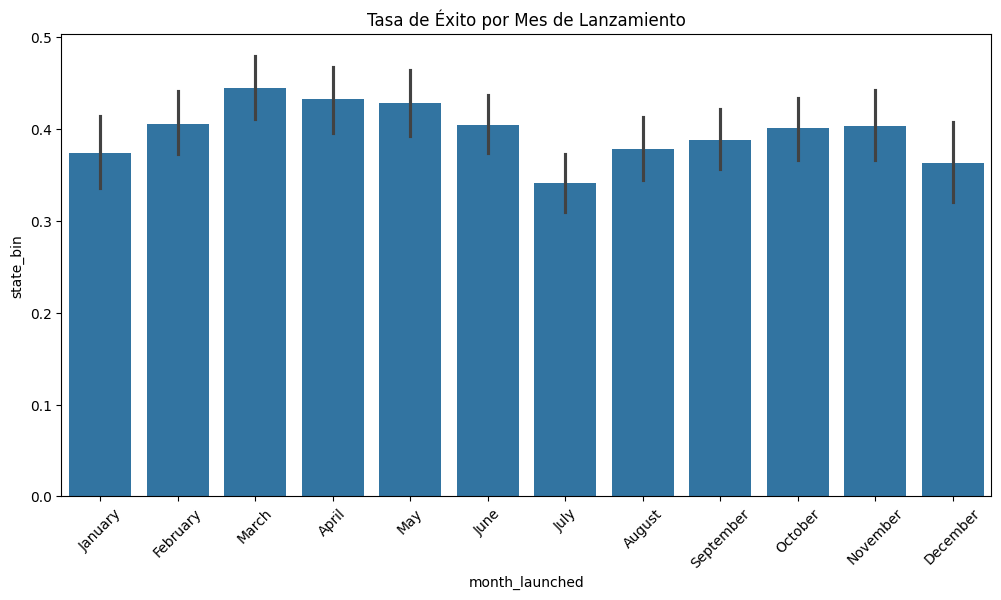

In [41]:
# Creamos la duración del proyecto en días
df['duration_days'] = (df['deadline'] - df['launched']).dt.days

# Extraemos mes y día de la semana
df['month_launched'] = df['launched'].dt.month_name()
df['day_launched'] = df['launched'].dt.day_name()

# Visualizamos la tasa de éxito por mes
plt.figure(figsize=(12, 6))
# Calculamos la tasa de éxito (promedio de 'state' convertido a binario)
# Primero convertimos state a 1 (successful) y 0 (failed) para calcular promedios
df['state_bin'] = df['state'].map({'successful': 1, 'failed': 0})

sns.barplot(x='month_launched', y='state_bin', data=df, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Tasa de Éxito por Mes de Lanzamiento')
plt.xticks(rotation=45)
plt.show()

# 3. MANEJO DE ALTA CARDINALIDAD
### El Problema
La columna `category` o `main_category` puede tener muchas opciones. Si hacemos One-Hot Encoding, explotamos el número de columnas (Maldición de la Dimensionalidad).

In [42]:
print(f"Número de categorías únicas: {df['category'].nunique()}")
print(df['category'].value_counts().head(10))

Número de categorías únicas: 155
category
Product Design    464
Documentary       405
Music             343
Shorts            343
Food              314
Tabletop Games    286
Video Games       239
Film & Video      225
Fiction           218
Fashion           205
Name: count, dtype: int64


#### Solución 1: Agrupación (Top N + Other)
Nos quedamos con las más frecuentes y agrupamos el resto.

In [43]:
top_10_categories = df['category'].value_counts().nlargest(10).index
df['category_grouped'] = df['category'].apply(lambda x: x if x in top_10_categories else 'Other')

print(df['category_grouped'].value_counts())

category_grouped
Other             5696
Product Design     464
Documentary        405
Shorts             343
Music              343
Food               314
Tabletop Games     286
Video Games        239
Film & Video       225
Fiction            218
Fashion            205
Name: count, dtype: int64


#### Solución 2: Target Encoding
Reemplazamos la categoría por la probabilidad promedio de éxito de esa categoría.
**¡Cuidado!** Esto puede causar *Data Leakage* si no se hace con validación cruzada, pero para EDA es muy útil para visualizar.

In [44]:
# Calculamos el promedio de éxito por categoría
target_map = df.groupby('category')['state_bin'].mean()

# Mapeamos
df['category_encoded'] = df['category'].map(target_map)

df[['category', 'state_bin', 'category_encoded']].head()

,category,state_bin,category_encoded
0,Product Design,0,0.387931
1,Publishing,0,0.299213
2,Design,1,0.420000
3,Indie Rock,1,0.711765
5,Art,1,0.463542


# 4. PROCESAMIENTO DE TEXTO BÁSICO (NLP)
### Objetivo
¿Influye el nombre del proyecto? Vamos a extraer métricas simples.

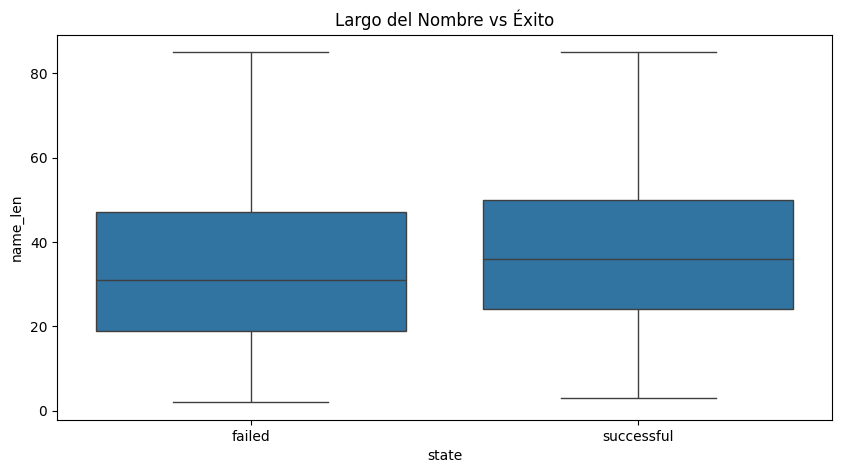

In [45]:
# Largo del nombre (caracteres)
df['name_len'] = df['name'].astype(str).apply(len)

# Conteo de palabras
df['word_count'] = df['name'].astype(str).apply(lambda x: len(x.split()))

# Visualización
plt.figure(figsize=(10, 5))
sns.boxplot(x='state', y='name_len', data=df)
plt.title('Largo del Nombre vs Éxito')
plt.show()

# 5. ANÁLISIS MULTIVARIADO Y OUTLIERS
### El Problema del "Goal"
La meta financiera (`goal`) tiene un rango enorme. Visualizarla directamente es difícil.

Antes de realizar cualquier transformación, es fundamental visualizar la distribución original de las variables numéricas para detectar valores atípicos (outliers). En este caso, observaremos la variable `goal`.

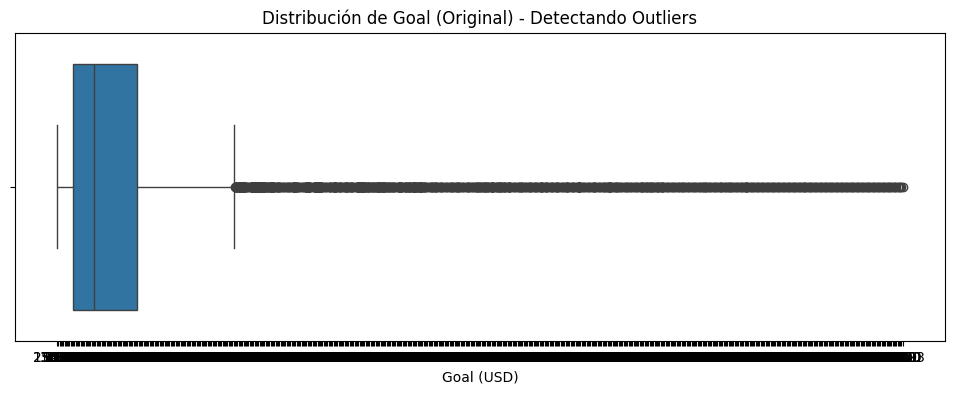

In [46]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=df['goal'])
plt.title('Distribución de Goal (Original) - Detectando Outliers')
plt.xlabel('Goal (USD)')
plt.show()

**Observación:** Como se puede apreciar en el gráfico de caja (boxplot), la variable `goal` tiene un rango extremadamente amplio con outliers muy lejanos. Esto hace que la "caja" principal (donde está la mayoría de los datos) se vea como una línea aplastada a la izquierda.

Para corregir este sesgo y visualizar mejor la relación con otras variables, aplicaremos una **transformación logarítmica** (`np.log1p`).

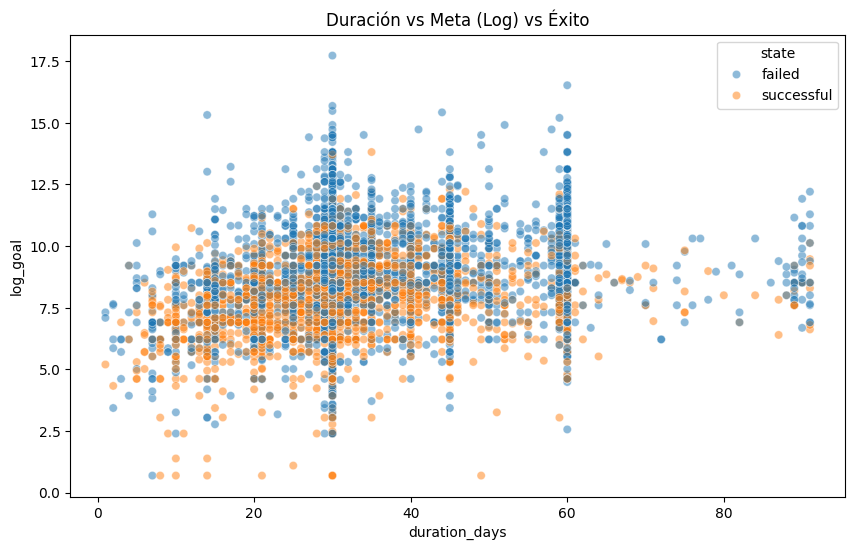

In [47]:
# Transformación Logarítmica para suavizar la distribución
# Aseguramos que 'goal' sea numérico (puede venir como texto si el CSV estaba sucio)
df['goal'] = pd.to_numeric(df['goal'], errors='coerce')

# Aplicamos logaritmo (log1p calcula log(1+x) para evitar error con log(0))
df['log_goal'] = np.log1p(df['goal'])

# Scatterplot Multivariado
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_days', y='log_goal', hue='state', data=df, alpha=0.5)
plt.title('Duración vs Meta (Log) vs Éxito')
plt.show()

> **Análisis:**
> 
> - **La Trampa de la Ambición:** Observamos una clara tendencia: cuanto mayor es la meta financiera (`log_goal` alto), más puntos naranjas (failed) vemos. Pedir demasiado dinero es un factor de riesgo.
> - **Duración:** No parece haber una relación lineal fuerte entre duración y éxito, aunque los proyectos extremadamente largos a veces pierden "momentum".
> - **Zona de Éxito:** La mayoría de los proyectos exitosos (azules) se concentran en metas moderadas.

# 6. REDUCCIÓN DE DIMENSIONALIDAD (PCA)
### Objetivo
Ver nuestros datos multidimensionales en 2D.

### ¿Por qué Estandarizar (StandardScaler)?
PCA es muy sensible a la escala de los datos. Si una variable se mide en millones (ej. `goal`) y otra en unidades pequeñas (ej. `duration_days`), PCA pensará que la variable grande es mucho más importante solo por ser un número más grande.
**StandardScaler** pone todas las variables en la misma "regla" (media 0, desviación estándar 1) para que compitan en igualdad de condiciones.

### ¿Qué es PCA (Principal Component Analysis)?
Es una técnica matemática que "aplasta" muchas dimensiones (variables) en pocas (Componentes Principales), tratando de perder la menor cantidad de información posible.

- **PC1:** Es la dirección donde los datos varían más.
- **PC2:** Es la segunda dirección más importante (perpendicular a la primera).

Nos permite visualizar en un gráfico 2D un dataset que tiene 6 o más dimensiones.

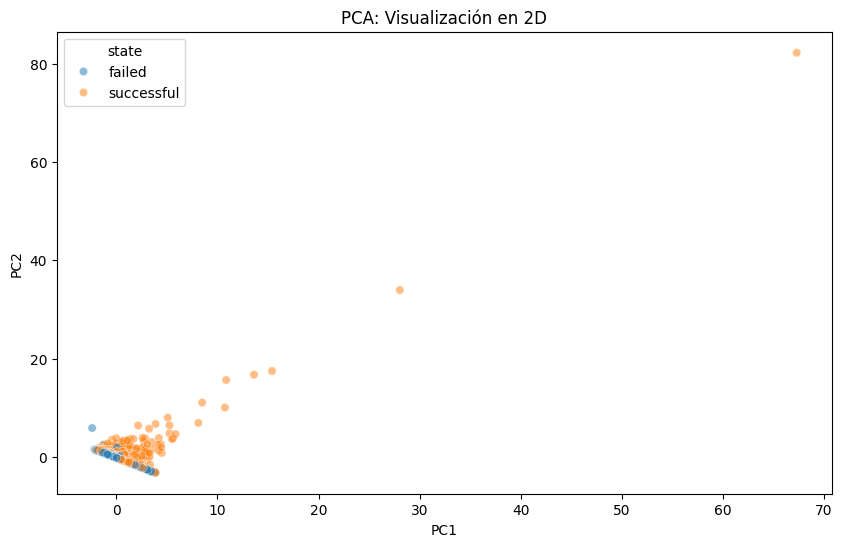

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Seleccionamos variables numéricas
features = ['duration_days', 'goal', 'name_len', 'word_count', 'backers', 'usd pledged']
# Limpiamos nulos que hayan podido quedar
df_pca = df[features].dropna()

# 1. Estandarización (Obligatorio para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# 2. PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Agregamos el target para colorear (teniendo cuidado con los índices si hubo dropna)
pca_df['state'] = df.loc[df_pca.index, 'state'].values

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='state', data=pca_df, alpha=0.5)
plt.title('PCA: Visualización en 2D')
plt.show()

> **Análisis**
> 
> - **Mezcla de Clases:** Si ves que los puntos azules (successful) y naranjas (failed) están muy mezclados, significa que el problema es difícil. Un modelo lineal simple (como Regresión Logística) podría no ser suficiente.
> - **Separación:** Si ves grupos claros, ¡genial! El modelo tendrá un trabajo fácil.
> - **Varianza:** Los ejes PC1 y PC2 capturan la mayor parte de la información. Si los puntos están muy dispersos, hay mucha variabilidad en tus datos.

# 7. TEST ESTADÍSTICO (CHI-SQUARE)
### Objetivo
Validar si la categoría principal (`main_category`) realmente influye en el éxito.

In [49]:
from scipy.stats import chi2_contingency

# Tabla de contingencia
contingency_table = pd.crosstab(df['main_category'], df['state'])

# Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"P-value: {p}")
if p < 0.05:
    print("Rechazamos la hipótesis nula: Hay una relación significativa entre la Categoría y el Éxito.")
else:
    print("No hay evidencia suficiente para decir que influye.")

P-value: 1.847174668435891e-92
Rechazamos la hipótesis nula: Hay una relación significativa entre la Categoría y el Éxito.


### **Explicación del Análisis:**

1.  **¿Qué hicimos?**
    Creamos una **tabla de contingencia** (`pd.crosstab`) que cuenta cuántos proyectos exitosos y fallidos hay por cada categoría. Luego, aplicamos la prueba **Chi-Cuadrado de Independencia** (`chi2_contingency`).

2.  **¿Para qué?**
    Queremos saber si el éxito de un proyecto depende de su categoría o si es puramente aleatorio.
    -   **Hipótesis Nula ($H_0$):** No hay relación (son independientes). La categoría no importa.
    -   **Hipótesis Alternativa ($H_1$):** Sí hay relación (son dependientes). La categoría influye en el éxito.

3.  **Interpretación:**
    -   Si el **P-value < 0.05**, rechazamos $H_0$. Concluimos que **la categoría SÍ influye** en la probabilidad de éxito.
    -   Si el **P-value >= 0.05**, no podemos descartar que sea azar.

# 8. CONCLUSIÓN
En este nivel hemos abordado la complejidad de los datos del mundo real. Hemos aprendido a detectar y corregir errores de codificación y formato, a manejar variables con alta cardinalidad mediante agrupamiento, y a extraer información valiosa de fechas y texto. Además, hemos aplicado técnicas avanzadas como la transformación logarítmica para corregir sesgos, PCA para reducir la dimensionalidad y tests estadísticos para validar hipótesis.

### Resumen de la Progresión:

- **Nivel 1:** Inspección básica, limpieza de nulos, gráficos univariados.
- **Nivel 2:** Tipos de datos, One-Hot Encoding, Correlaciones.
- **Nivel 3:** Fechas, NLP básico, Alta Cardinalidad, Logaritmos, PCA y Tests Estadísticos.